In [1]:
import os

import numpy as np
from PIL import Image
from tqdm import tqdm

from rtnls_registration import Registration
from rtnls_registration.evaluation import validate

gt_dir = "FIRE/Ground Truth"
im_dir = "FIRE/Images"

def load_image(path):
    return np.array(Image.open(path))

def load_item(filename):

    _, _, case, r, q = filename[:-4].split("_")
    query_path = f"{im_dir}/{case}_{q}.jpg"
    refer_path = f"{im_dir}/{case}_{r}.jpg"

    points = np.loadtxt(f"{gt_dir}/{filename}")

    return {
        "case": case,
        "refer_path": refer_path,
        "query_path": query_path,
        "refer_points": points[:, :2],
        "query_points": points[:, 2:],        
        "category": case[0]
    }

items = {
    x: load_item(x)
    for x in os.listdir(gt_dir)
    if x.endswith(".txt") and not x.endswith("P37_1_2.txt")
}

In [2]:
registrator = Registration()
for name, item in tqdm(items.items()):
    query = load_image(item["query_path"])
    refer = load_image(item["refer_path"])    
    item["transform"] = registrator(query, refer)

100%|██████████| 133/133 [07:01<00:00,  3.17s/it]


In [3]:
scores, aucs = validate(items)
for k, v in aucs.items():
    print(f"{k:5}: {v:.3f}")

S    : 0.945
P    : 0.887
A    : 0.769
total: 0.906


In [4]:
from collections import Counter
print('Inaccurate:', Counter([score['inaccurate'] for score in scores.values()]))

print('Root mean square error:')
for cat in 'SPA':
    rmse = [score['RMSE'] for score in scores.values() if score['category'] == cat]
    print(f'{cat:5}: {np.mean(rmse):.3f} ({np.std(rmse):.3f})')
total = [score['RMSE'] for score in scores.values()]
print(f'total: {np.mean(total):.3f} ({np.std(total):.3f})')


Inaccurate: Counter({np.False_: 133})
Root mean square error:
S    : 1.551 (0.540)
P    : 2.863 (1.420)
A    : 5.479 (3.440)
total: 2.438 (1.894)


avg_error           : 0.866
max_error           : 1.902
median_error        : 0.623
RMSE                : 0.703


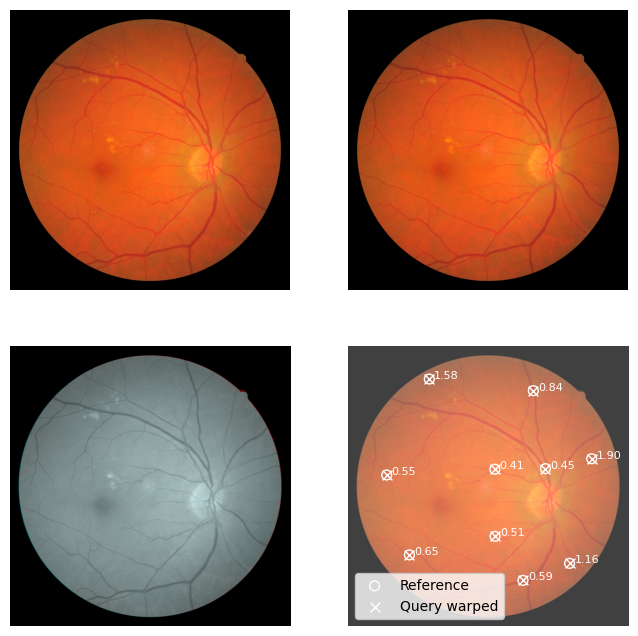

In [5]:
from rtnls_registration.utils import plot_points

best_name, best_score = min(scores.items(), key=lambda x: x[1]['RMSE'])
item = items[best_name]
query = load_image(item["query_path"])
refer = load_image(item["refer_path"])
plot_points(item, query, refer)

avg_error           : 17.335
max_error           : 40.702
median_error        : 14.107
RMSE                : 15.320


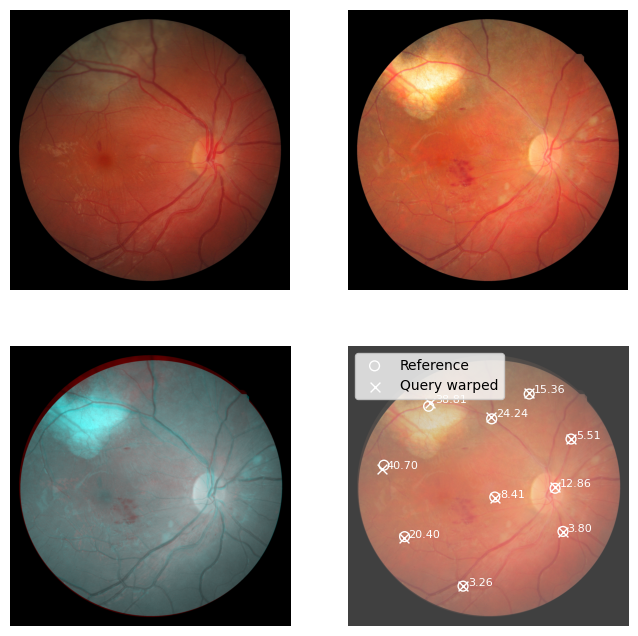

In [6]:
worst_name, worst_score = max(scores.items(), key=lambda x: x[1]['RMSE'])
item = items[worst_name]
query = load_image(item["query_path"])
refer = load_image(item["refer_path"])
plot_points(item, query, refer)